### importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import glob 
import matplotlib.pyplot as plt
import urllib
import zipfile
import os
from scipy.fft import rfft, rfftfreq

### Obtenção dos dados

In [2]:
# Download dos arquivos
# urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/imbalance.zip', 'imbalance.zip')
# urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/normal.zip', 'normal.zip')

# # extração dos arquivos
# with zipfile.ZipFile('imbalance.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')
# with zipfile.ZipFile('normal.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

# # excluir arquivos .zip
# os.remove('normal.zip')
# os.remove('imbalance.zip')

### Verificação de dados inválidos

In [2]:
def dataReader(path_names):
    data = []
    for i in path_names:
        data_file = pd.read_csv(i,header=None)
        data.append(data_file)
    return np.array(data)

In [4]:
def checkNullValues(path_names):
    for file in path_names:
        data = pd.read_csv(file, header=None)
        nullValues = data.isnull().sum()
        if any(nullValues > 0):
            print('CSV file {} has null values'.format(file))

In [5]:
# normal_file_names = glob.glob('./data/normal/*.csv')
# imbalance6g_file_names = glob.glob('./data/imbalance/6g/*.csv')
# imbalance10g_file_names = glob.glob('./data/imbalance/10g/*.csv')
# imbalance15g_file_names = glob.glob('./data/imbalance/15g/*.csv')
# imbalance20g_file_names = glob.glob('./data/imbalance/20g/*.csv')
# imbalance25g_file_names = glob.glob('./data/imbalance/25g/*.csv')
# imbalance30g_file_names = glob.glob('./data/imbalance/30g/*.csv')
# imbalance35g_file_names = glob.glob('./data/imbalance/35g/*.csv')

# checkNullValues(normal_file_names)
# checkNullValues(imbalance6g_file_names)
# checkNullValues(imbalance10g_file_names)
# checkNullValues(imbalance15g_file_names)
# checkNullValues(imbalance20g_file_names)
# checkNullValues(imbalance25g_file_names)
# checkNullValues(imbalance30g_file_names)
# checkNullValues(imbalance35g_file_names)

In [6]:
def plotSignalSample(dataSample):
    timeAxes = np.arange(0 ,5, 1/50000)
    figure, axis = plt.subplots(8,1, figsize=(12,15),  constrained_layout=True)
    axis[0].plot(timeAxes, dataSample[0])
    axis[1].plot(timeAxes, dataSample[1])
    axis[2].plot(timeAxes, dataSample[2])
    axis[3].plot(timeAxes, dataSample[3])
    axis[4].plot(timeAxes, dataSample[4])
    axis[5].plot(timeAxes, dataSample[5])
    axis[6].plot(timeAxes, dataSample[6])
    axis[7].plot(timeAxes, dataSample[7])
    figure.supxlabel('Seconds')
    figure.supylabel('Voltage')

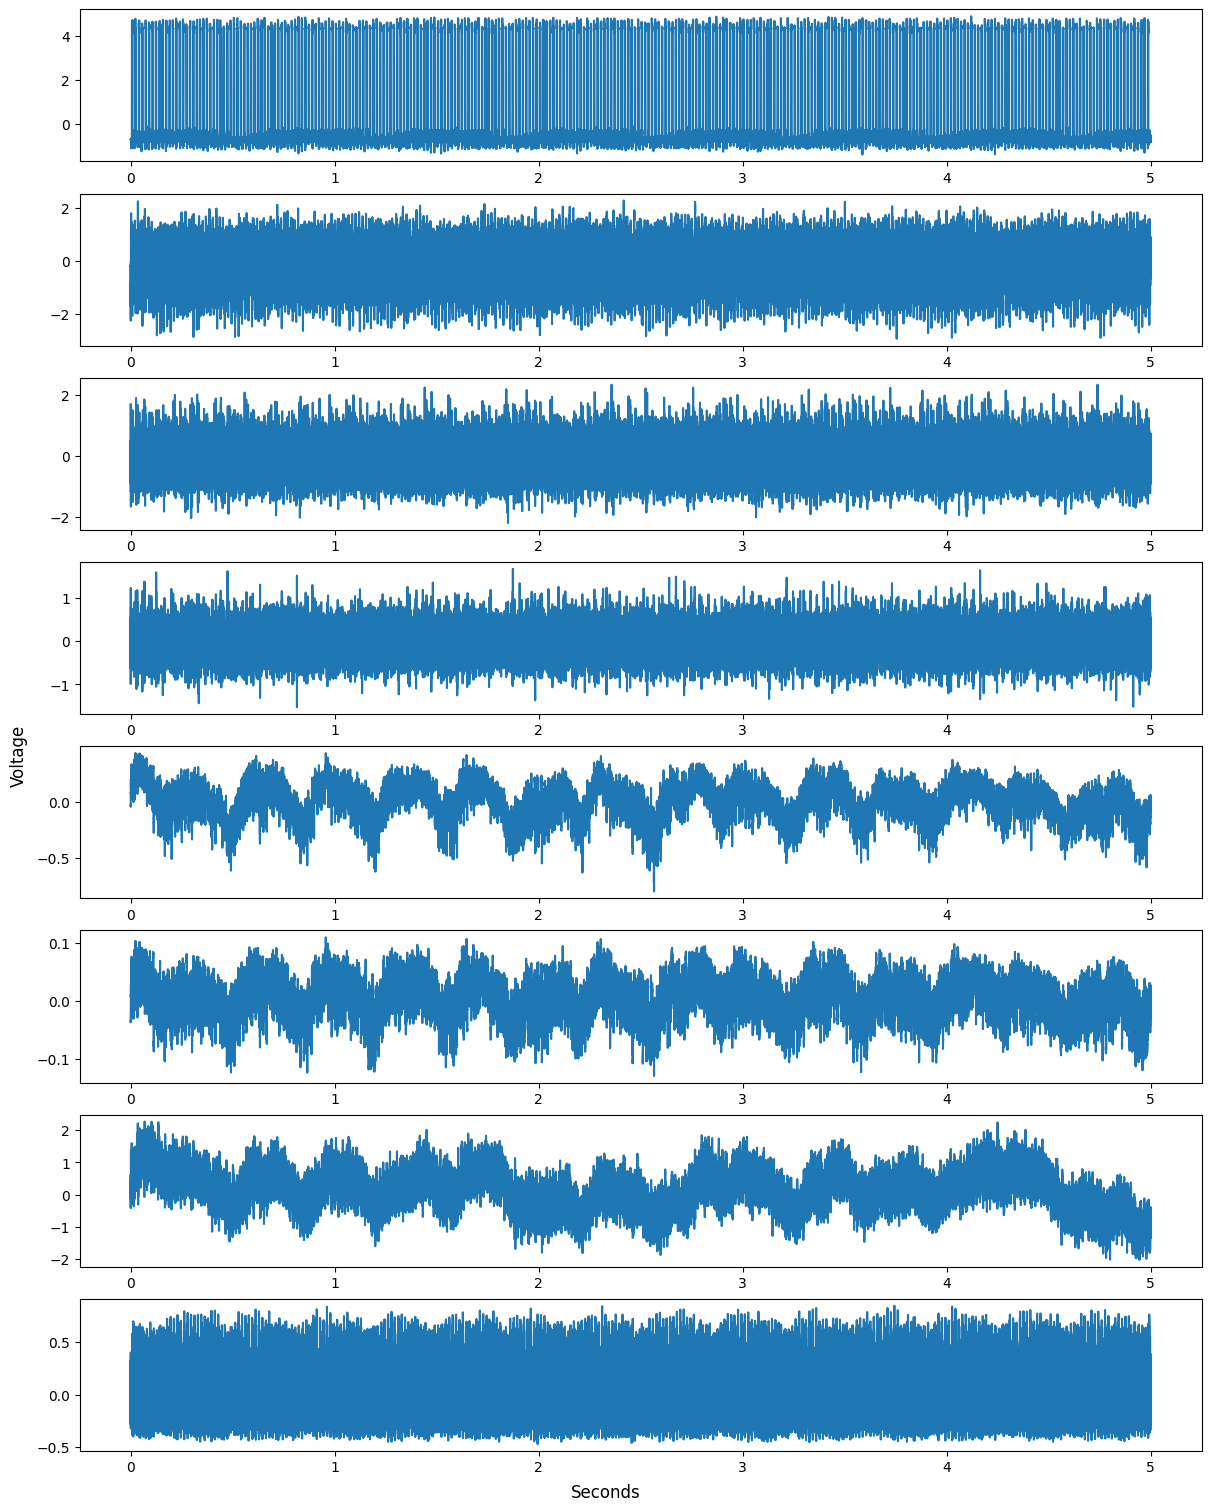

In [7]:
normalSample = pd.read_csv('./data/normal/61.44.csv', header=None)
plotSignalSample(normalSample)


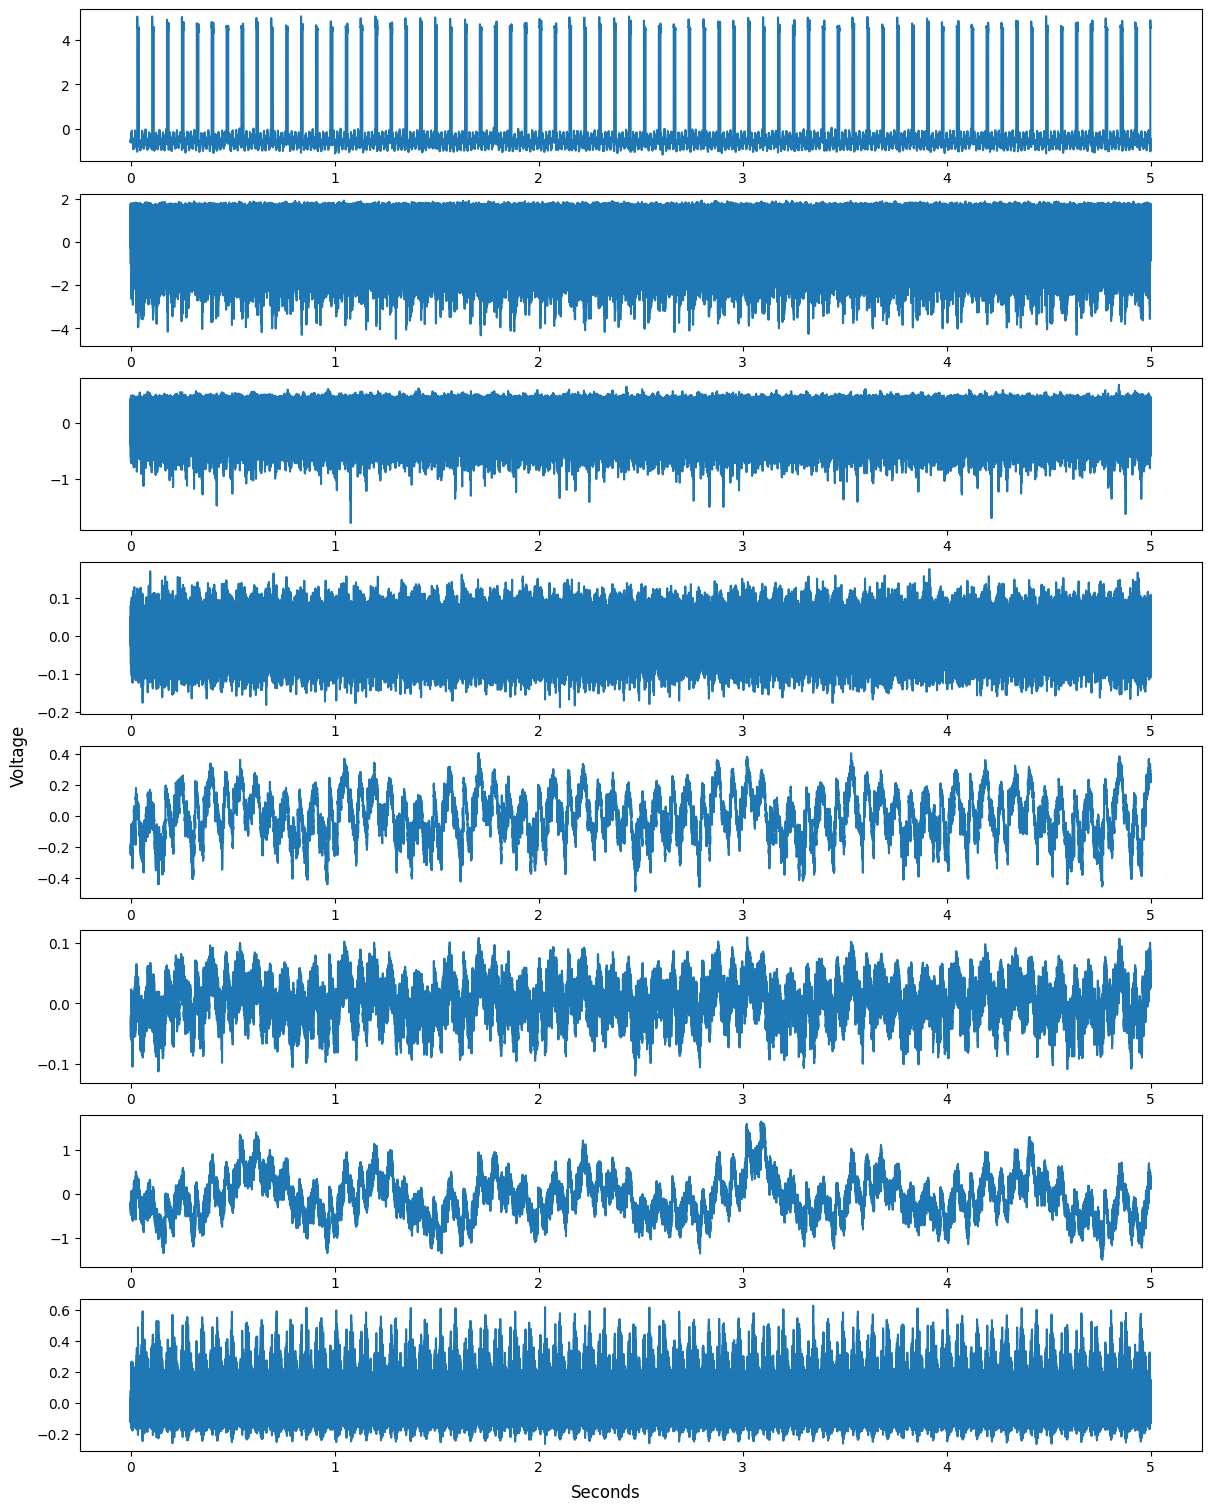

In [8]:
imbalance6gSample = pd.read_csv('./data/imbalance/6g/13.9264.csv', header=None)
plotSignalSample(imbalance6gSample)

Deste gráfico chegamos a 2 conclusões:
- Dados não estão na mesma escala, o que pode enviesar o algoritmo de machine learn.
- Alta taxa de amostragem (50kHz), o que tornará o processo de treinamento muito lento.

In [3]:
def resample(data, sample_target_rate):
    data_resampled = pd.DataFrame()
    period = 5 # seconds
    step = int(len(data)/period / sample_target_rate )
    start_index = 0
    stop_index = step
    for i in range(0, len(data), step):
        # data_resampled = pd.concat([data_resampled, data[start_index:stop_index].mean().to_frame().T], axis=0, ignore_index=True) ## para funcionar com dataframe
        temp_df =  pd.DataFrame([data[start_index:stop_index].mean(axis=0)])
        # data_resampled = pd.concat([data_resampled, temp_df], ignore_index=True, axis=0) # para ndarray
        data_resampled = pd.concat([data_resampled, temp_df], ignore_index=True) 
        start_index += step
        stop_index += step
   
    return data_resampled


In [4]:
target_rate = 500
ORIGINAL_SAMPLE_RATE = 50000 # taxa de amostragem original dos dados

In [5]:
normalSample = pd.read_csv('./data/normal/61.44.csv', header=None)
a = normalSample.to_numpy() 
normalSampleResampled = resample(a, target_rate)
# imbalance6gSampleResampled = resample(imbalance6gSample, target_rate)
normalSampleResampled.shape

(2500, 8)

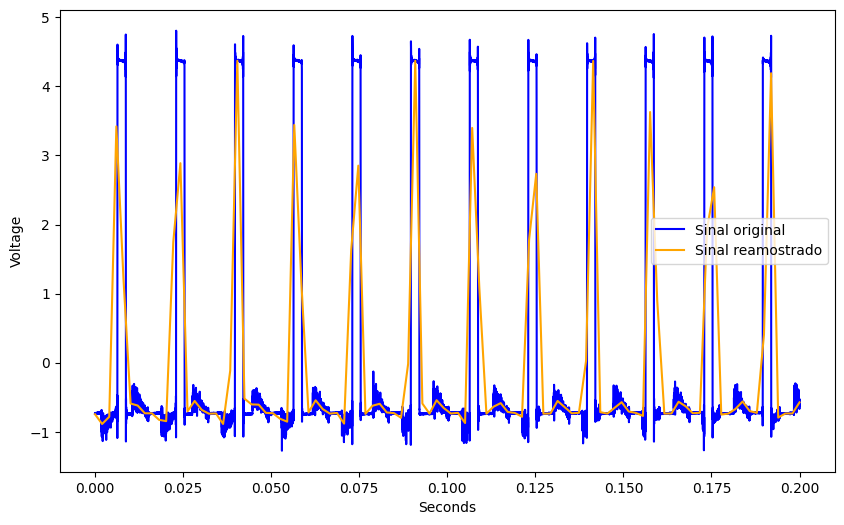

In [6]:
# plot 0,2s dos dados originais e reamostrados para comparação
# usado valor 10000 e 100, pois é 1/5 da taxa de amostragem original. pois esta sendo plotado 0,2s (1/5 de segundo)
time = 0.2 # s
qty_original_samples =  int(ORIGINAL_SAMPLE_RATE * time)
qty_resampled_sample = int(target_rate * time)
t1 = np.linspace(0, time, qty_original_samples)
t2 = np.linspace(0, time, qty_resampled_sample)
plt.figure(figsize=(10, 6))
plt.plot(t1,  normalSample[0][0:qty_original_samples], label='Sinal original', color='blue')
plt.plot(t2,  normalSampleResampled[0][0:qty_resampled_sample], label='Sinal reamostrado', color='orange')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.legend() 


podemos observar que há perdas nos dados. Será testado diferentes frequencias de reamostragem para encontrar o melhor  trade-off entre a precisão dos dados e o custo de treinamento.

modelos que podem ser usados
LSTM
dnn
knn
svm


In [7]:
def apply_fft(signal, sample_rate):
    N = signal.shape[0]
    T = 1 / sample_rate
    yf = np.fft.fftn(signal)
    xf = np.fft.fftfreq(N, T)[:N//2] # obtem somente frequencias positivas, pois o espectro é simétrico
    spectrum = 2.0/N * np.abs(yf)[:N//2] # normalização
    return spectrum, xf

In [45]:
# def apply_rfft(data, sample_rate):
#     # Calcular a Transformada de Fourier usando rfftn
#     spectrum = np.fft.rfftn(data)
    
#     # Calcular as frequências correspondentes
#     freqs = np.fft.rfftfreq(len(data), d=1/sample_rate)
#     # freqs = [np.fft.fftfreq(n, d=1/sample_rate) for n in data.shape]
#     return spectrum, freqs

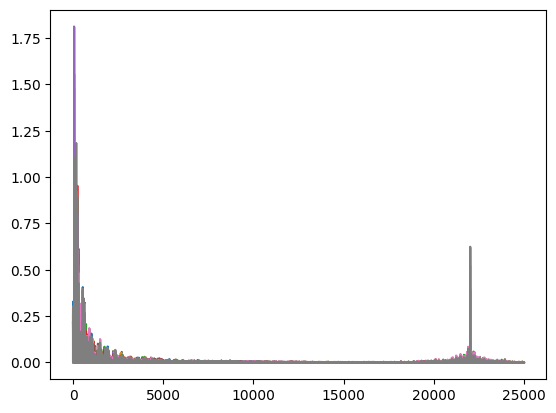

In [15]:
normal_sample_spectrum, xf = apply_fft(normalSample, ORIGINAL_SAMPLE_RATE)   
plt.plot(xf,normal_sample_spectrum)


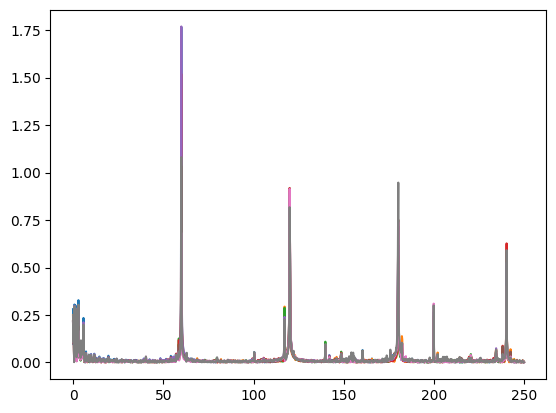

In [8]:
normal_sample_spectrum_resampled, xf_resampled = apply_fft(normalSampleResampled, target_rate)   
plt.plot(xf_resampled,normal_sample_spectrum_resampled)


In [ ]:
# imbalance6g_resample_spectrum, xf_imbalance6g_resampled = apply_fft(imbalance6gSampleResampled, target_rate)   
# plt.plot(xf_imbalance6g_resampled, imbalance6g_resample_spectrum)

## processamento de dados
aqui os dados serão tratados para uso nos modelos de machine learn

In [9]:
def apply_rfft(signal, sampling_rate):
    """
    Aplica a Transformada Rápida de Fourier Real (RFFT) a um sinal de entrada.

    Parâmetros:
    signal (numpy array): O sinal de entrada.
    sampling_rate (float): A taxa de amostragem do sinal.

    Retorna:
    tuple: Frequências e coeficientes da RFFT.
    """
    # Aplicar RFFT
    rfft_result = np.abs(np.fft.rfft(signal, axis=0)) / signal.shape[0]
    rfft_freqs = np.fft.rfftfreq(len(signal), d=1/sampling_rate)
    
    # spectrum = np.fft.rfftn(data)
    
#     # Calcular as frequências correspondentes
#     freqs = np.fft.rfftfreq(len(data), d=1/sample_rate)
#     # freqs = [np.fft.fftfreq(n, d=1/sample_rate) for n in data.shape]

    return rfft_result, rfft_freqs 

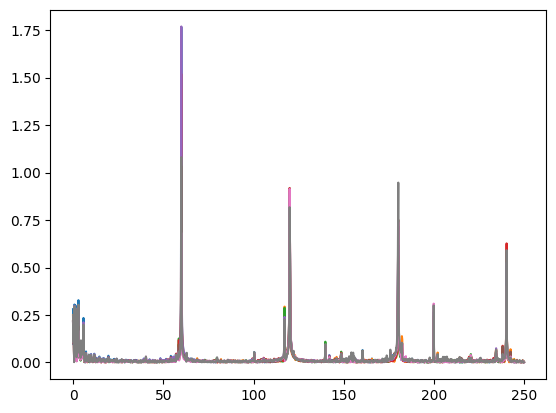

In [10]:
normal_sample_spectrum_resampled, xf_resampled = apply_fft(normalSampleResampled, target_rate)   
plt.plot(xf_resampled,normal_sample_spectrum_resampled)

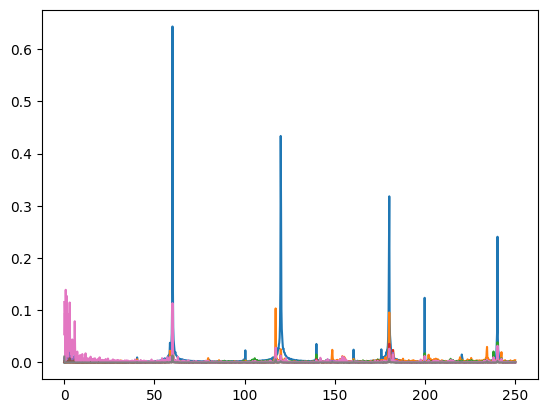

In [11]:
normal_sample_spectrum_resampled_r, xf_resampled_r = apply_rfft(normalSampleResampled, target_rate)   
plt.plot(xf_resampled_r, normal_sample_spectrum_resampled_r)

In [12]:
def dataReader2d(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i,header=None)
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return np.array(data_n)

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def scalerData(data):
    # scaler = StandardScaler()
    # return scaler.fit_transform(data)
    return MinMaxScaler().fit_transform(data)



In [47]:
# verificar outliers
from scipy import stats

data_normal_check_outlier = dataReader2d(glob.glob('./data/normal/*.csv'))

z_scores = np.abs(stats.zscore(data_normal_check_outlier, axis=0))
# Definir um limiar para considerar um valor como outlier
threshold = 3

# Identificar outliers
outliers = (z_scores > threshold)

# Exibir os outliers
outliers_array = data_normal_check_outlier[np.any(outliers, axis=1)]
print("Outliers encontrados:")
print(outliers_array)

Outliers encontrados:
[[ 4.5651    -2.6384    -0.47423   ... -0.021352  -0.12896    0.18728  ]
 [ 4.5813    -2.7736    -0.63237   ... -0.018791  -0.085526   0.31766  ]
 [ 4.5683    -2.8077    -0.53075   ... -0.011058   0.0059215  0.18387  ]
 ...
 [-0.67835    0.55293    0.36659   ...  0.016274  -1.3207    -0.25761  ]
 [-0.8083    -0.20402   -0.24101   ...  0.017698  -1.2752     0.23496  ]
 [-0.70556    0.29555    0.30236   ... -0.025549  -1.2631    -0.13658  ]]


In [14]:
def process_data(files_folder):
    processed_data = []
    # data = dataReader(files_folder)
    # for i in range(len(data)):
    #     data_resampled = resample(data[i], target_rate)
    #     spectrum, xf = apply_fft(data_resampled, target_rate)
    #     processed_data.append(spectrum)

    data = dataReader2d(files_folder)
    # dataScaled = scalerData(data)

    data_resampled = resample(data, target_rate)
    spectrum, xf = apply_rfft(data_resampled, target_rate)
    # processed_data.append(spectrum)

    return spectrum


In [22]:
data_normal = process_data( glob.glob('./data/normal/*.csv'))

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data_normal = process_data( glob.glob('./data/normal/*.csv'))
data_imbalance35g= process_data( glob.glob('./data/imbalance/35g/*.csv'))

X = np.concatenate((data_normal, data_imbalance35g), axis=0)

y_classes = np.concatenate((np.full(data_normal.shape[0], 'normal'), np.full(data_imbalance35g.shape[0], 'imbalance35g')), axis=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_classes)


X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=1)

# SVM

In [16]:
from sklearn.svm import SVC
svc = SVC(random_state=1)
svc.fit(X_train, y_train)
print("SVM accuracy is {} on Train Dataset".format(svc.score(X_train,y_train)))
print("SVM accuracy is {} on Test Dataset".format(svc.score(X_test,y_test)))

SVM accuracy is 0.9514925373134329 on Train Dataset
SVM accuracy is 0.952076677316294 on Test Dataset


In [41]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
svc = SVC(random_state=1)
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)

# Executar a busca em grade
grid_search.fit(X_train, y_train)
print("Melhores hiperparâmetros: ", grid_search.best_params_)

best_svc = grid_search.best_estimator_
print("Acuracidade no conjunto de treino: ", best_svc.score(X_train, y_train))
print("Acuracidade no conjunto de teste: ", best_svc.score(X_test, y_test))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, classification_report
import seaborn as sns

def plot_model_performance(y_test, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues',cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    print(class_report_df)

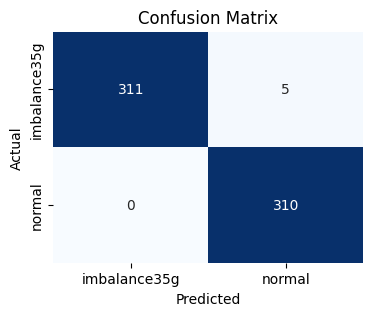

              precision    recall  f1-score     support
0              1.000000  0.984177  0.992026  316.000000
1              0.984127  1.000000  0.992000  310.000000
accuracy       0.992013  0.992013  0.992013    0.992013
macro avg      0.992063  0.992089  0.992013  626.000000
weighted avg   0.992140  0.992013  0.992013  626.000000


In [40]:
y_pred = best_svc.predict(X_test)

plot_model_performance(y_test, y_pred, label_encoder.classes_)

  0%|          | 0/100 [00:00<?, ?it/s]

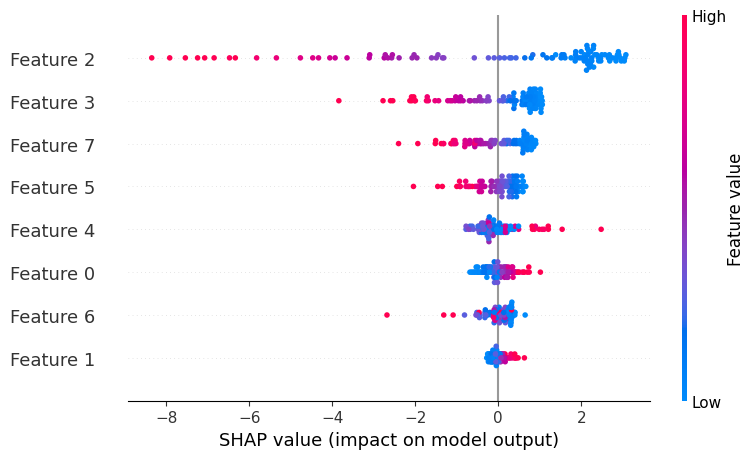

In [52]:
import shap

X_train_sample = shap.sample(X_train, 100)  

explainer = shap.KernelExplainer(best_svc.decision_function, X_train_sample)
# Calcular os valores SHAP
shap_values = explainer.shap_values(X_train_sample)

# Visualizar a importância das features
shap.summary_plot(shap_values, X_train_sample)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


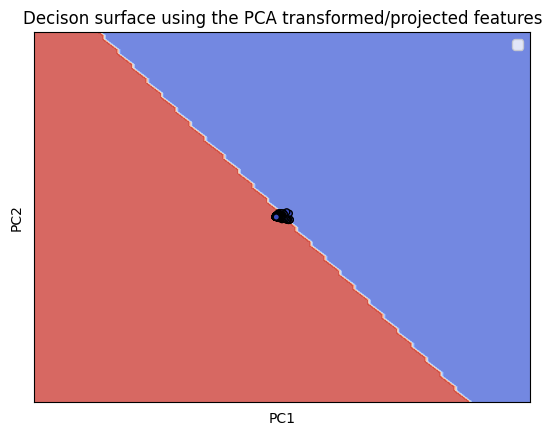

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='linear')
clf = model.fit(Xreduced, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

# KNN


In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5) #n_neighbors = k
knn.fit(X_train, y_train)
print("k={}NN Accuracy on Train Data: {}".format(3,knn.score(X_train, y_train)))
print("k={}NN Accuracy on Test Data: {}".format(3,knn.score(X_test, y_test)))

k=3NN Accuracy on Train Data: 0.9195095948827292
k=3NN Accuracy on Test Data: 0.8993610223642172


In [43]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()

# Configurar a busca em grade
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# Melhor estimador
best_knn = grid_search.best_estimator_

# Avaliar o modelo
print("Acuracidade no conjunto de treino: ", best_knn.score(X_train, y_train))
print("Acuracidade no conjunto de teste: ", best_knn.score(X_test, y_test))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Melhores hiperparâmetros:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Acuracidade no conjunto de treino:  1.0
Acuracidade no conjunto de teste:  0.9249201277955271


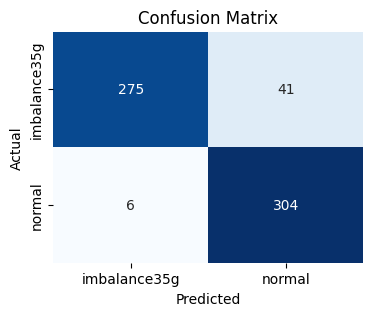

              precision    recall  f1-score    support
0              0.978648  0.870253  0.921273  316.00000
1              0.881159  0.980645  0.928244  310.00000
accuracy       0.924920  0.924920  0.924920    0.92492
macro avg      0.929904  0.925449  0.924759  626.00000
weighted avg   0.930371  0.924920  0.924725  626.00000


In [45]:
y_pred_knn = best_knn.predict(X_test)

plot_model_performance(y_test, y_pred_knn, label_encoder.classes_)

# Gradient Boosting


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train, y_train)
print("Gradient Boosting accuracy on Train Dataset: {}".format(gbc.score(X_train, y_train)))
print("Gradient Boosting accuracy on Test Dataset: {}".format(gbc.score(X_test, y_test)))

Gradient Boosting accuracy on Train Dataset: 1.0
Gradient Boosting accuracy on Test Dataset: 0.9904153354632588


In [44]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Inicializar o modelo Gradient Boosting
gb = GradientBoostingClassifier()

# Configurar a busca em grade
grid_search = GridSearchCV(gb, param_grid, cv=5, verbose=2, n_jobs=-1)

# Executar a busca em grade
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# Melhor estimador
best_gb = grid_search.best_estimator_

# Avaliar o modelo
print("Acuracidade no conjunto de treino: ", best_gb.score(X_train, y_train))
print("Acuracidade no conjunto de teste: ", best_gb.score(X_test, y_test))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Melhores hiperparâmetros:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
Acuracidade no conjunto de treino:  1.0
Acuracidade no conjunto de teste:  0.9904153354632588


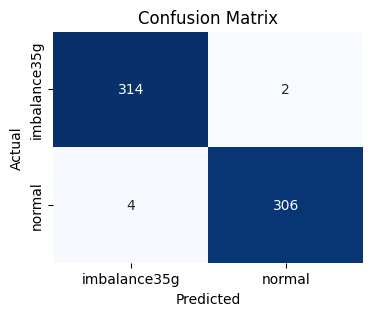

              precision    recall  f1-score     support
0              0.987421  0.993671  0.990536  316.000000
1              0.993506  0.987097  0.990291  310.000000
accuracy       0.990415  0.990415  0.990415    0.990415
macro avg      0.990464  0.990384  0.990414  626.000000
weighted avg   0.990435  0.990415  0.990415  626.000000


In [46]:
y_pred_gb = best_gb.predict(X_test)

plot_model_performance(y_test, y_pred_gb, label_encoder.classes_)

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=2)
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(8,),kernel_initializer='random_uniform'))
model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(7, activation='softmax',kernel_initializer='random_uniform'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                288       
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 7)                 231       
                                                                 
Total params: 21287 (83.15 KB)
Trainable params: 2128

In [87]:
hist = model.fit(X_train , y_train , epochs=20, validation_split=0.2)

Epoch 1/20
47/47 [==============================] - 5s 18ms/step - loss: 1.8220 - accuracy: 0.5000 - val_loss: 1.3778 - val_accuracy: 0.4920
Epoch 2/20
47/47 [==============================] - 0s 10ms/step - loss: 0.8023 - accuracy: 0.5187 - val_loss: 0.6958 - val_accuracy: 0.5080
Epoch 3/20
47/47 [==============================] - 0s 8ms/step - loss: 0.6960 - accuracy: 0.5120 - val_loss: 0.6942 - val_accuracy: 0.5080
Epoch 4/20
47/47 [==============================] - 0s 7ms/step - loss: 0.6949 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.5080
Epoch 5/20
47/47 [==============================] - 1s 12ms/step - loss: 0.6962 - accuracy: 0.4907 - val_loss: 0.6938 - val_accuracy: 0.5080
Epoch 6/20
47/47 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.4827 - val_loss: 0.6933 - val_accuracy: 0.5080
Epoch 7/20
47/47 [==============================] - 0s 8ms/step - loss: 0.6969 - accuracy: 0.4880 - val_loss: 0.6959 - val_accuracy: 0.5080
Epoch 8/20
47/47

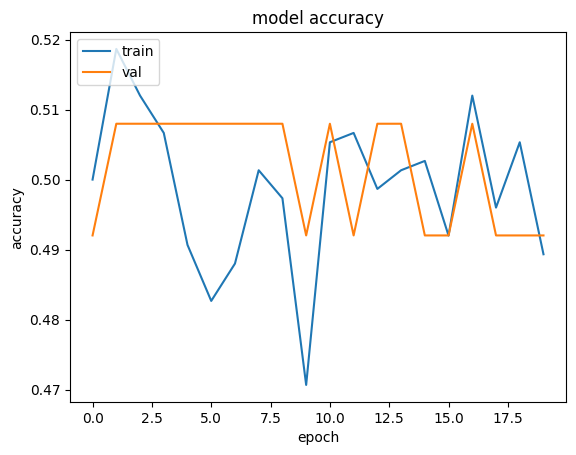

In [88]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train_3d = np.expand_dims(X_train, axis=1)
X_test_3d = np.expand_dims(X_test, axis=1)


model = Sequential()
model.add(LSTM(50, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train_3d, y_train, epochs=100, batch_size=100, validation_data=(X_test_3d, y_test))

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

Epoch 1/100
19/19 [==============================] - 10s 137ms/step - loss: 1.7644 - accuracy: 0.4400 - val_loss: 1.7309 - val_accuracy: 0.4096
Epoch 2/100
19/19 [==============================] - 0s 13ms/step - loss: 1.6967 - accuracy: 0.5045 - val_loss: 1.6528 - val_accuracy: 0.4816
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 1.6086 - accuracy: 0.4955 - val_loss: 1.5522 - val_accuracy: 0.5120
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 1.4986 - accuracy: 0.4965 - val_loss: 1.4304 - val_accuracy: 0.5120
Epoch 5/100
19/19 [==============================] - 0s 12ms/step - loss: 1.3707 - accuracy: 0.4960 - val_loss: 1.2960 - val_accuracy: 0.5120
Epoch 6/100
19/19 [==============================] - 0s 14ms/step - loss: 1.2359 - accuracy: 0.4960 - val_loss: 1.1623 - val_accuracy: 0.5120
Epoch 7/100
19/19 [==============================] - 0s 20ms/step - loss: 1.1083 - accuracy: 0.4960 - val_loss: 1.0436 - val_accuracy: 0.5120
Epoc

TypeError: in user code:

    File "c:\Users\Ricardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\Ricardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Ricardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\Ricardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\Ricardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Ricardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_5' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_5' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None
